In [1]:
 # Import libraries 
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import SVC
import imutils
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
dataset = pd.read_csv('pic_lable.csv')

In [3]:
# Separating the target and the features
x = dataset['img']
y = dataset['lable']
size = x.size
new_images = []

In [4]:
def extractSkin(img):
    # Taking a copy of the image
    #img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

In [5]:
def removeBlack(x):
    # Array to store the skin image after removing black
    images = []

    for i in range(len(x)):

         # Converting from BGR Colours Space to gray
        tmp = cv2.cvtColor(x[i], cv2.COLOR_BGR2GRAY)

         # Global thresholding
        _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)

         # Get rgb values from image
        b, g, r = cv2.split(x[i])

         # Assign new color values to image
        rgba = [b,g,r, alpha]
        dst = cv2.merge(rgba,4)

         # Store new image in the array
        images.append(dst)

    return images


In [6]:
for i in range(size):
    im = x[i]
    image = cv2.imread(im)
    gray = extractSkin(image)
    new_images.append(gray)

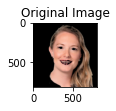

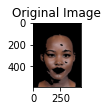

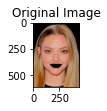

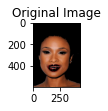

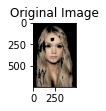

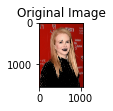

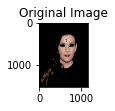

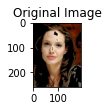

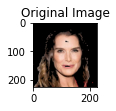

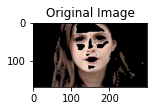

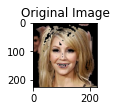

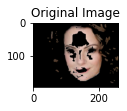

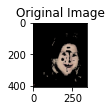

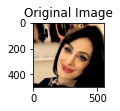

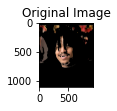

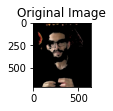

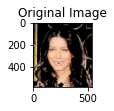

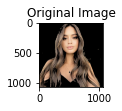

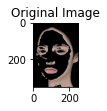

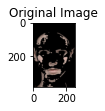

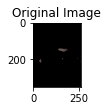

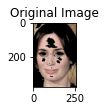

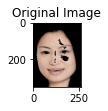

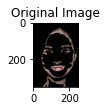

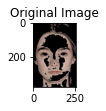

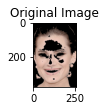

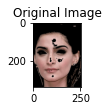

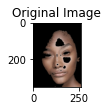

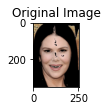

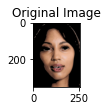

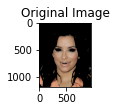

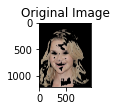

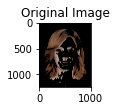

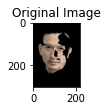

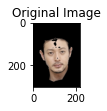

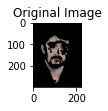

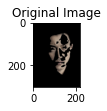

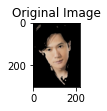

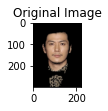

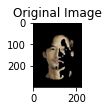

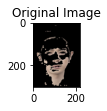

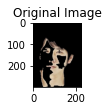

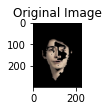

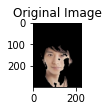

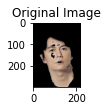

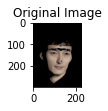

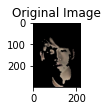

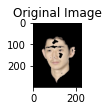

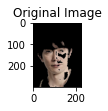

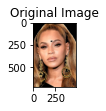

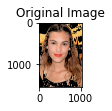

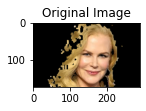

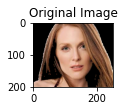

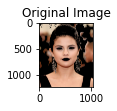

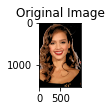

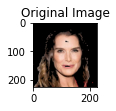

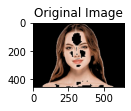

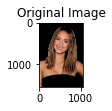

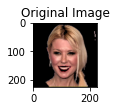

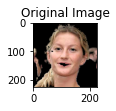

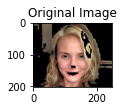

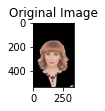

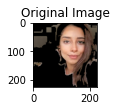

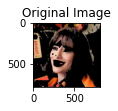

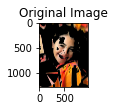

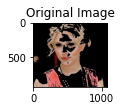

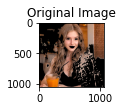

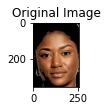

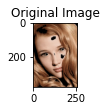

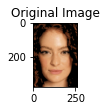

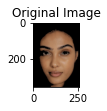

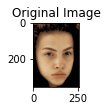

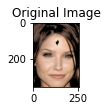

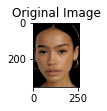

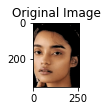

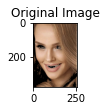

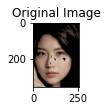

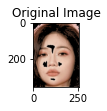

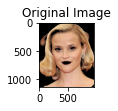

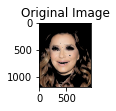

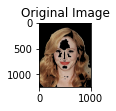

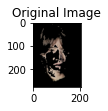

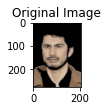

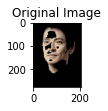

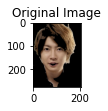

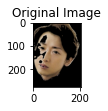

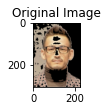

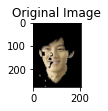

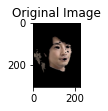

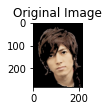

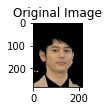

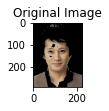

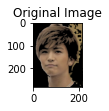

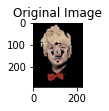

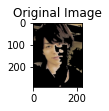

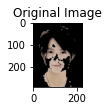

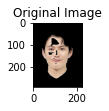

In [7]:
for i in range(size):
    plt.subplot(3, 1, 1)
    plt.imshow(cv2.cvtColor(new_images[i], cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.show()

In [8]:
def printImage(im):
     for i in range(len(im)):
            plt.subplot(3, 1, 1)
            plt.imshow(cv2.cvtColor(im[i], cv2.COLOR_BGR2RGB))
            plt.show()

In [9]:
def skinDetect(x):
 
        # Array to store the skin image after extraction
        images = []

        for i in range(x.size):

            # Iterating on all x
            img = x[i]

            # Read the image
            image = cv2.imread(img)

            # Resize the image
            new_im = imutils.resize(image,width=800, height=800)

            # Call extractSkin function
            skin = extractSkin(new_im)

            # Store new image in the array
            images.append(skin)

        return images

In [10]:
def getColor(x):
        # Number of colors to be extracted
        clusters = 2

        # Array to store extracted color
        c = []

        # Array to store new colors of all images
        colors = []

        for i in range(len(x)):

            # Iterating on all x
            img = x[i]

            # Call dominantColors to get colors list
            dc = DominantColors(img, clusters)
            colors_list = dc.dominantColors()

            # Store the dominant color if not black
            if (colors_list[0].all() != 0):
                c = colors_list[0]
                colors.append(c)
            else:
                c = colors_list[1]
                colors.append(c)

        return colors

In [11]:
class DominantColors:
    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image

    def dominantColors(self):
        # read image
        img_src = self.IMAGE
        # percent by which the image is resized
        scale_percent = 10
        # calculate the 50 percent of original dimensions
        width = int(img_src.shape[1] * scale_percent / 100)
        height = int(img_src.shape[0] * scale_percent / 100)
        # dsize
        dsize = (width, height)
        # resize image
        small_img = cv2.resize(img_src, dsize)
        # convert to rgb from bgr
        img = cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB)
        # reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        # save image after operations
        self.IMAGE = img
        # using k-means to cluster pixels
        kmeans = KMeans(n_clusters=self.CLUSTERS)
        kmeans.fit(img)
        # the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        # save labels
        self.LABELS = kmeans.labels_
        # returning after converting to integer from float
        return self.COLORS.astype(int)
    def plotHistogram(self):
 
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)

        #create frequency count tables
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()

        #appending frequencies to cluster centers
        colors = self.COLORS

        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()]

        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0

        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500

            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]

            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end

        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()
        

In [12]:
# Call skinDetect to detect skin on x data
skin = skinDetect(x)

In [13]:
 # Call removeBlack on skin data to remove black color
skin_NoBlack = removeBlack(skin)

In [14]:
# Call getColor on skin_NoBlack to get color of skin
colors = getColor(skin_NoBlack)

In [15]:
# Convert array to data frame
X = pd.DataFrame(colors)

In [16]:
# Split dataset to training and testing sets
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3,random_state=0)

In [17]:
# Train the support vector machine algorithm
svm = SVC(C=0.1, kernel='linear', degree=3, gamma=1)
svm.fit(X_train,y_train)
# Test the model on X_test
y_pred1 = svm.predict(X_test)
print('Prediction results of SVM model on the test dataset')
print('---------------------------------------------------')
print(classification_report(y_test, y_pred1))


Prediction results of SVM model on the test dataset
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.40      0.46        15
           1       0.53      0.67      0.59        15

    accuracy                           0.53        30
   macro avg       0.54      0.53      0.52        30
weighted avg       0.54      0.53      0.52        30



In [18]:
 # Train the Logistic Regression algorithm
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train,y_train)
# Test the model on X_test
y_pred3 =LR.predict(X_test)
print('Prediction results of Logistic Regression model on the test dataset')
print('-------------------------------------------------------------------')
print(classification_report(y_test, y_pred3))

Prediction results of Logistic Regression model on the test dataset
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        15
           1       0.57      0.80      0.67        15

    accuracy                           0.60        30
   macro avg       0.62      0.60      0.58        30
weighted avg       0.62      0.60      0.58        30



In [19]:
# Train the Logistic Regression algorithm
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train,y_train)
# Test the model on X_test
y_pred3 =LR.predict(X_test)
print('Prediction results of Logistic Regression model on the test dataset')
print('-------------------------------------------------------------------')
print(classification_report(y_test, y_pred3))

Prediction results of Logistic Regression model on the test dataset
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        15
           1       0.57      0.80      0.67        15

    accuracy                           0.60        30
   macro avg       0.62      0.60      0.58        30
weighted avg       0.62      0.60      0.58        30

